In [2]:
using DrWatson
@quickactivate "Doran_etal_2022"

using Muon
using Distances
using StatsPlots
using NewickTreeTools
using Statistics
using Phylo
using SPI

In [85]:
pdir = plotsdir("UPvsBB_predictions")
mkpath(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/UPvsBB_predictions"

In [3]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"));

In [4]:
# Match BioBank measurements to column order of UniProt
bbmtx = zeros(size(biobank["oggs"].X, 1), length(uniprot.var_names.vals));
rawidxs = indexin(biobank["oggs"].var_names.vals, uniprot.var_names.vals)
bbmask = .!isnothing.(rawidxs)
uporderedmask = filter(x->.!isnothing(x), rawidxs);
bbmtx[:, uporderedmask] .= biobank["oggs"].X[:, :][:, bbmask];

In [5]:
length(uporderedmask)

5036

In [6]:
UPusv = SVD(uniprot.obsm["LSVs"][:, :], uniprot.uns["SVs"][:], uniprot.varm["RSVs"][:, :]');

In [7]:
UPlsv = uniprot.obsm["LSVs"][:, :]
BBuhat = projectinLSV(bbmtx, UPusv);

In [8]:
combinedLSVs = vcat(UPlsv, BBuhat)

7720×7047 Matrix{Float64}:
 -0.0114586    -0.0216582     0.019895     …  -0.00343279    0.000169521
 -0.00767793   -0.00636277   -0.0131315       -0.000434615   0.000610293
 -0.0130113    -0.00435805   -0.0099335       -0.000182124   0.00380136
 -0.000602711  -0.000988808   0.000752653      0.0886084    -0.0722487
 -0.00206376   -0.0033936    -0.00111579      -0.00422126   -0.000817393
 -0.0114336     0.00822375   -0.00379274   …  -0.00301883    0.00110319
 -0.0227615     0.0193921    -0.002939         0.001856      0.000376359
 -0.0115215    -0.0114664    -0.00368027      -0.00593608   -0.00406709
 -0.00607869   -0.00275552   -0.00193346       0.00147964   -0.000988248
 -0.00917458   -0.00687051   -0.0125918        0.0025059    -0.00064466
  ⋮                                        ⋱   ⋮            
 -0.00895884   -0.0207339     0.0178657        0.106219     -0.317428
 -0.00903688   -0.0208161     0.0180687        0.118437     -0.345223
 -0.0129656    -0.0307315     0.027649        -0

In [10]:
UPvsBB = calc_spi_mtx(combinedLSVs, UPusv.S, getintervals(UPusv.S));

In [11]:
using MAT
matwrite(
    datadir("exp_pro", "BB673", "UPvsBBdists.mat"),
    Dict("dists"=>UPvsBB ./ 10117)
)

In [12]:
UPvsBB = matread(datadir("exp_pro", "BB673", "UPvsBBdists.mat"))["dists"];

In [22]:
predictions = UPvsBB[1:7047, 7048:end];
@show size(predictions);

size(predictions) = (7047, 673)


In [19]:
r_gnavus_idxs = occursin.("gnavus", biobank.obs.species) |> findall
b_vulgatus_idxs = occursin.("vulgatus", biobank.obs.species) |> findall;
popat!(b_vulgatus_idxs, occursin.("MSK.7.24", biobank.obs_names[b_vulgatus_idxs]) |> findfirst)

162

In [120]:
length(b_vulgatus_idxs)

93

In [32]:
establishedUPtaxa = findall(.!occursin.("sp.", uniprot.obs.Species));

In [40]:
nonestablishedUPtaxa = findall(occursin.("sp.", uniprot.obs.Species));

In [45]:
nneighbors = mapslices(x->sortperm(x)[1:5], predictions[:, :], dims=1)

5×673 Matrix{Int64}:
 5760   292   292  6930  1990  1990  …  5114   954  2381   292  5114   954
 4425  3861  3861  3925  2252  2252     3289  4129  2252  3861  3289  4129
 1990  4427  3925  3289  4425  4425      266   779   100  3925   266   779
 5055  3925  3289   266   266   266     4671  4330  1771   266  4671  4330
 3289  4671  4427  5596  3289  3289     4852  3587  6930  3289  4852  3587

In [46]:
nneighbors[1, r_gnavus_idxs] |> unique

2-element Vector{Int64}:
 3208
 3978

In [50]:
(nneighbors[1, r_gnavus_idxs] .== 3208) |> sum

40

In [47]:
uniprot.obs.Species[nneighbors[1, r_gnavus_idxs] |> unique]

2-element Vector{String}:
 "[Ruminococcus] gnavus CAG:126"
 "Dorea sp. CAG:105"

In [56]:
uniprot.obs_names[nneighbors[1, r_gnavus_idxs] |> unique]

2-element Vector{String}:
 "UP000018114"
 "UP000017921"

In [26]:
nneighbors[1, b_vulgatus_idxs] |> unique

1-element Vector{Int64}:
 6930

In [52]:
UPtree = NewickTree.readnw(read(open(projectdir("_research", "runSPIonUP7047rows", "2020_02_UP7047-trimmedtree.nw")), String));

In [54]:
leaves = NewickTree.getleaves(UPtree);

In [101]:
leafid = findfirst(x->contains(name(x),"UP000018114"), leaves)
compose(f, n) = reduce(∘, ntuple(_ -> f, n))
subtree = compose(parent, 4)(leaves[leafid]);

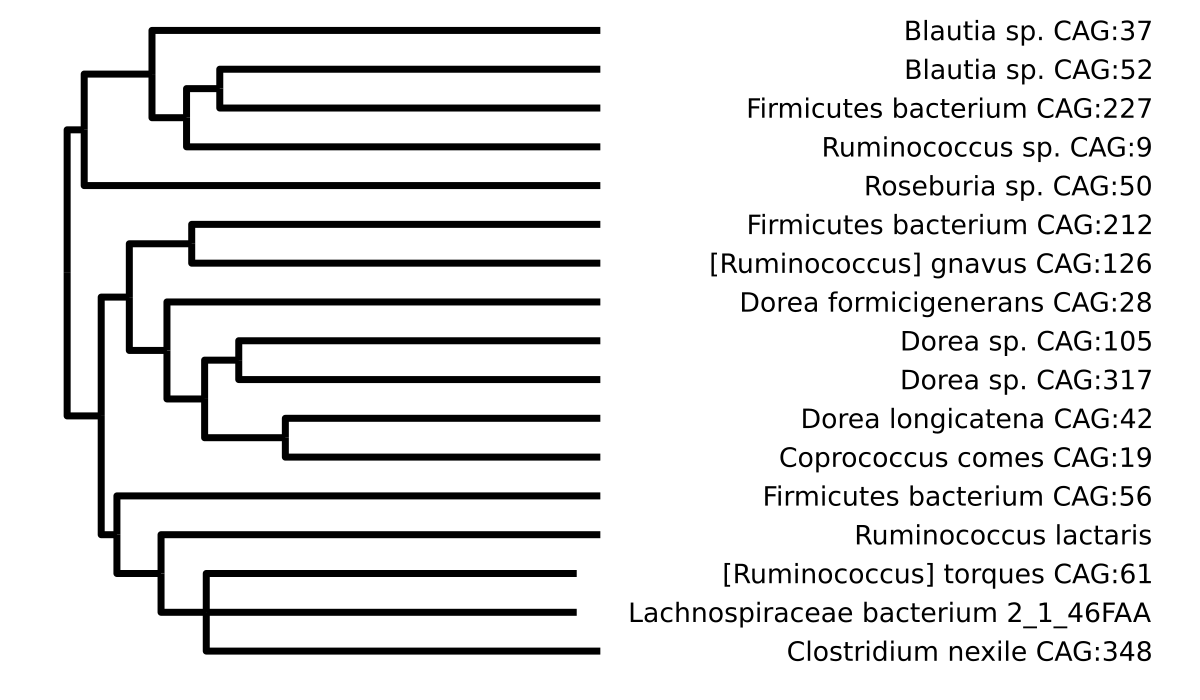

In [103]:
plotsubtree = parsenewick(NewickTree.nwstr(subtree))
# sort!(plotsubtree)
Phylo.getleafnames(plotsubtree)
plot(plotsubtree, rightmargin=13Plots.Measures.cm, 
    lw=7, 
    size=(1200, 700), 
    showtips=false)
tipnames = uniprot.obs.Species[indexin(Phylo.getleafnames(plotsubtree), uniprot.obs_names)]
annotate!(2.9, 1:length(tipnames), text.(tipnames, 18, :right))

In [104]:
savefig(joinpath(pdir, "Rgnavus_UniProtSubtree.pdf"))

## Vugatus subtree

In [106]:
uniprot.obs_names[nneighbors[1, b_vulgatus_idxs] |> unique]

1-element Vector{String}:
 "UP000002861"

In [113]:
leafid = findfirst(x->contains(name(x),"UP000002861"), leaves)
compose(f, n) = reduce(∘, ntuple(_ -> f, n))
subtree = compose(parent, 1)(leaves[leafid]);

In [114]:
plotsubtree = parsenewick(NewickTree.nwstr(subtree))

RootedTree with 9 tips, 17 nodes and 16 branches.
Leaf names are UP000006731, UP000000566, UP000236725, UP000285678, UP000094877, UP000018199, UP000196154, UP000001218 and UP000002861


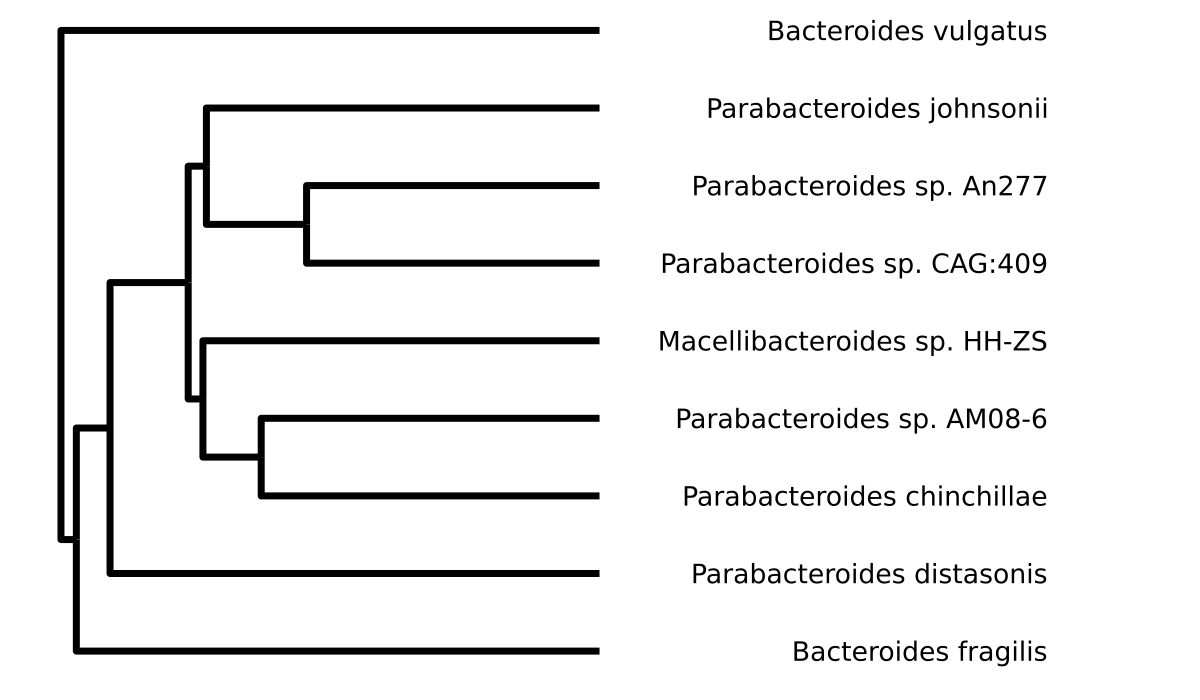

In [118]:
plotsubtree = parsenewick(NewickTree.nwstr(subtree))
# sort!(plotsubtree)
Phylo.getleafnames(plotsubtree)
plot(plotsubtree, rightmargin=13Plots.Measures.cm, 
    lw=7, 
    size=(1200, 700), 
    showtips=false)
tipnames = uniprot.obs.Species[indexin(Phylo.getleafnames(plotsubtree), uniprot.obs_names)]
annotate!(4, 1:length(tipnames), text.(tipnames, 18, :right))

In [119]:
savefig(joinpath(pdir, "Bvulgatus_UniProtSubtree.pdf"))